# Prototype a Streamlit Web Application: LCIA QSAR Model

**Date:** October 20, 2023

Streamlit is a Python library for turning data scripts into simple web applications. Streamlit also offers a Community Cloud for developers to freely deploy web applications directly from a GitHub repository, provided that the repository stays below a 1 GB resource limit. 

Here is an example of a Streamlit application designed for cheminformatics: https://molecule-icon-generator.streamlit.app/#molecule-icon-generator

I've been working on prototyping a Streamlit application for the LCIA QSAR Model in this Jupyter notebook. I thought it could be helpful to provide a user two options:
1. Lookup pre-computed data for a chemical and effect category of interest
2. Predict the point of departure for a new chemical

In [1]:
%matplotlib notebook

from rdkit import Chem
import pandas as pd
import numpy as np
import os
import json
import joblib

import plot

## Setup and function definitions

In [2]:
# Load the app configuration file
with open('config.json', 'r') as file:
    config = json.load(file)

def read_parquet(
    file_name,
    data_directory='Data',
    effect=None
    ):
    '''
    '''
    full_path = get_data_path(
        file_name, 
        data_directory=data_directory, 
        effect=effect
    )
    return pd.read_parquet(full_path)

def read_estimator(
    effect,
    file_name='estimator.joblib', 
    data_directory='Data'
    ):
    '''
    '''
    full_path = get_data_path(
        file_name, 
        data_directory=data_directory, 
        effect=effect
    )
    return joblib.load(full_path)

def get_data_path(
    file_name, 
    data_directory='Data', 
    effect=None
    ):
    '''
    '''
    effect_directory = effect if effect else ''
    
    directory_path = os.path.join(
        data_directory, 
        effect_directory
    )
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        
    return os.path.join(directory_path, file_name)

def show_qsar_ready_structure(dtxsid):
    smiles = smiles_for_dtxsid[dtxsid]
    return Chem.MolFromSmiles(smiles)

def get_features(dtxsid):
    return X.loc[dtxsid]

def get_point_of_departure(dtxsid):
    return f'{y_pred.loc[dtxsid]} [mg/(kg-d)]'

def plot_single_chemical_moe(ax, moe_results, dtxsid, color='#B22222'):
    '''
    Plots a single chemical's MOE data on the given Axes for all percentiles.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw on.
    chemical_data : pd.Series
        Series containing MOE data for the chemical.

    Returns
    -------
    None
    '''
    # Get the MOE data for the specific chemical
    chemical_data = pd.concat(moe_results, axis=1).loc[dtxsid].swaplevel()

    # Slice data for all percentiles
    moes = chemical_data.loc['moe']
    cum_counts = chemical_data.loc['cum_count']
    lbs = chemical_data.loc['lb']
    ubs = chemical_data.loc['ub']

    # Plot the MOE as red markers
    ax.scatter(moes, cum_counts, color=color, zorder=5)  # zorder ensures it's on top

    # Plot the horizontal lines representing the prediction intervals
    for cum_count, lb, ub in zip(cum_counts, lbs, ubs):
        ax.hlines(cum_count, lb, ub, colors=color, lw=1, zorder=4)
        
    # Extract data for all percentiles
    data = {
        "Percentile": chemical_data.index.get_level_values(1).unique(),
        "MOE": chemical_data.loc['moe'].values,
        "Cumulative Count": chemical_data.loc['cum_count'].values,
        "Lower Bound": chemical_data.loc['lb'].values,
        "Upper Bound": chemical_data.loc['ub'].values
    }

    return pd.DataFrame(data)

## Load pre-computed data from local files

In [3]:
smiles_for_dtxsid = read_parquet(config['chem_ids_file_name']).squeeze().to_dict()
exposure_df = read_parquet(config['exposure_file_name'])

In [4]:
# The user inputs the effect category
effect = 'general'

y_pred = read_parquet(config['pod_file_name'], effect=effect).squeeze()
X = read_parquet(config['features_file_name'], effect=effect)

moe_results = read_parquet(config['moe_file_name'], effect=effect)
exposure_percentiles = moe_results.columns.unique(level=0)
moe_results = {k : moe_results[k] for k in exposure_percentiles}

estimator = read_estimator(effect)

## Option 1: Lookup pre-computed data for ~450,000 chemicals

The user inputs an identifier (DTXSID) for a chemical within the applicability domain of SEEM3 that already has pre-computed data from our analysis.

In [5]:
chemical = 'DTXSID2021315'  # Dioxin

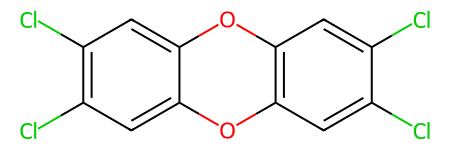

In [6]:
show_qsar_ready_structure(chemical)

In [7]:
get_features(chemical)

CATMoS_LD50_pred             6.800000e-01
ReadyBiodeg_pred_discrete    0.000000e+00
MP_pred                      3.020000e+02
CombDipolPolariz             2.419000e+00
ndHBdDon_discrete            0.000000e+00
nbN_discrete                 0.000000e+00
P_pred                       4.073803e+06
WS_pred                      3.090295e-10
TopoPolSurfAir               1.846000e+01
VP_pred                      1.584893e-09
Name: DTXSID2021315, dtype: float64

In [6]:
get_point_of_departure(chemical)

'7.989756292285504e-05 [mg/(kg-d)]'

<IPython.core.display.Javascript object>


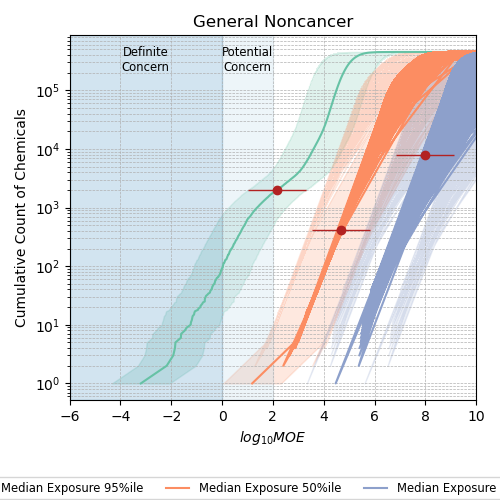

In [9]:
# Figure 5 of the manuscript

# FIXME: Rendering issue. Consider a workaround by pickling
fig, ax = plot.margins_of_exposure_cumulative(
    moe_results, 
    config['label_for_exposure_column'],
    config['label_for_effect'][effect],
    right_truncation=config['right_truncation']
)

In [10]:
plot_single_chemical_moe(ax, moe_results, chemical)

,Percentile,MOE,Cumulative Count,Lower Bound,Upper Bound
0,95th percentile (mg/kg/day),2.159523,1994.0,1.024659,3.294388
1,50th percentile (mg/kg/day),4.669212,417.0,3.534348,5.804077
2,5th percentile (mg/kg/day),7.976920,8017.0,6.842056,9.111785
